<a href="https://colab.research.google.com/github/evakato/ComputerVision4/blob/main/cv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
device = (
    #Nvidia GPU
    "cuda" 
    if torch.cuda.is_available()
    #Apple GPU
    else "mps"
    if torch.backends.mps.is_available()
    #Other
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


1. Import the Fashion MNIST dataset including the data labels. This would import two sets (training set and test set). Create a third set (validation set) by splitting the training set into two (training set and validation set) for validation purposes. Decide what a good ratio of training/validation is, and motivate your choice. You should use the validation set to evaluate the different choices you make when building your CNNs. Keep in mind that the test set will only be used at the very final stage and will not be included in the validation step.

In [29]:
import torchvision.transforms
from torchvision.transforms import ToTensor, Normalize
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt

#NOTE: data is not normalised yet
transform = torchvision.transforms.Compose([ToTensor(), Normalize((0.5,),(0.5,))]) #normalisation could probably be more accurate by calculating dataset mean and std
train_data = datasets.FashionMNIST('Data', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('Data', download=True, train=False, transform=transform)

splitlength = [50000,10000] 
#NOTE: This needs to be changed to be calculated using a percentage if we are going to have variable data lenghts (due to e.g. data augmentation)
train_data, val_data = random_split(train_data, splitlength)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

torch.Size([1, 28, 28]) 6


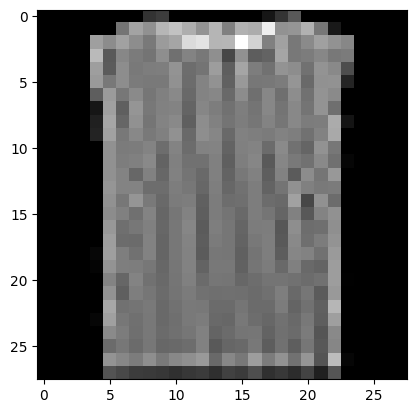

In [30]:
image, label = train_data[0]
print(image.shape, label)
plt.imshow(image[0], cmap = 'gray')

2. Recreate the LeNet-5 architecture as your baseline. The model takes as input a greyscale image of size 28x28x1 and has 10 outputs, one for each class. Make sure all parameters (number of neurons, number and size of kernels) is the same as in the original architecture. You may assume that no zero-padding was applied. The model is trained using cross-entropy loss, Adam optimizer with a learning rate of 0.001. Use torch.nn.init.kaiming_uniform to initialize your weights. Use a batch size of 32, unless your hardware doesn't allow you to. Then reduce the size accordingly.


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),  # 16 channels, 5x5 feature map size 
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [32]:
from torchkeras import summary

model = LeNet5()

def check_weights():
    for param in model.parameters():
        print(param.data)

def summarize(model):
    summary(model=model, input_shape=(1,28,28))

summarize(model)


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                             [-1, 6, 28, 28]                  156
ReLU-2                               [-1, 6, 28, 28]                    0
AvgPool2d-3                          [-1, 6, 14, 14]                    0
Conv2d-4                            [-1, 16, 10, 10]                2,416
ReLU-5                              [-1, 16, 10, 10]                    0
AvgPool2d-6                           [-1, 16, 5, 5]                    0
Flatten-7                                  [-1, 400]                    0
Linear-8                                   [-1, 120]               48,120
ReLU-9                                     [-1, 120]                    0
Linear-10                                   [-1, 84]               10,164
ReLU-11                                     [-1, 84]                    0
Linear-12                            

In [33]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train(loader, model, criterion, optimizer):
    size = len(loader.dataset)
    batches = len(loader)
    model.train()
    loss_list = []
    total_loss = 0

    for n, batch in enumerate(tqdm(loader)):
        X,y = batch
        optimizer.zero_grad()
        
        pred = model(X)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

def test(loader, model, criterion):
    size = len(loader.dataset)
    batches = len(loader)
    total_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in loader:
            X,y = batch
            pred = model(X)
            
            loss = criterion(pred, y)
            total_loss += loss.item()

            y = y.data.numpy()
            y_true.extend(y)
            pred = pred.argmax(1).data.numpy()
            y_pred.extend(pred)

    loss = total_loss / batches
    accuracy = accuracy_score(y_true, y_pred)

    #print(f"loss: {loss}\naccuracy: {accuracy}")
    return y_true, y_pred, loss, accuracy
        

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []
accs_train = []
accs_test = []

def train_test_loop(model, criterion, optimizer, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}\n----------------")
        print("Training:")
        train(loader=train_dataloader, model=model, criterion=criterion, optimizer=optimizer)
    
        print("Testing:")
        y_true_train, y_pred_train, loss_train, acc_train = test(loader=train_dataloader, model=model, criterion=criterion)
        print(f"train-set - loss: {loss_train}, accuracy: {acc_train}")
        y_true_test, y_pred_test, loss_test, acc_test = test(loader=val_dataloader, model=model, criterion=criterion)
        print(f"test-set - loss: {loss_test}, accuracy: {acc_test}")
    
        losses_train.append(loss_train)
        losses_test.append(loss_test)
        print("----------------")

    return y_true_test, y_pred_test

    

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix, classes, classes)
    sn.heatmap(conf_matrix, annot=True, fmt= 'g')
    cr = classification_report(y_true, y_pred, target_names=classes)
    print(cr)

def plot_loss(train_losses, test_losses, epochs):
    plt.plot(range(1, epochs+1), train_losses)
    plt.plot(range(1, epochs+1), test_losses)
    plt.show()

#print(losses_train, losses_test)
train_test_loop(model, criterion, optimizer, epochs)
#evaluate(y_true_test,y_pred_test)
#plot_loss(losses_train, losses_test, epochs)

'''
train-set - loss: 0.14023029249756147, accuracy: 0.94832
test-set - loss: 0.2626302895514062, accuracy: 0.9138
EPOCH 11
'''

Epoch 1
----------------
Training:


100%|██████████| 1563/1563 [00:29<00:00, 53.05it/s]


Testing:
train-set - loss: 0.3664657538369422, accuracy: 0.86532
test-set - loss: 0.3743048102948993, accuracy: 0.8585
----------------
Epoch 2
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.10it/s]


Testing:
train-set - loss: 0.29974067443773217, accuracy: 0.89048
test-set - loss: 0.3193826159349265, accuracy: 0.8842
----------------
Epoch 3
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.64it/s]


Testing:
train-set - loss: 0.27220929552272427, accuracy: 0.89836
test-set - loss: 0.30669122674880317, accuracy: 0.8897
----------------
Epoch 4
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.00it/s]


Testing:
train-set - loss: 0.25102233056572487, accuracy: 0.9043
test-set - loss: 0.2922363825404225, accuracy: 0.894
----------------
Epoch 5
----------------
Training:


100%|██████████| 1563/1563 [00:32<00:00, 47.74it/s]


Testing:
train-set - loss: 0.22779064147863645, accuracy: 0.9154
test-set - loss: 0.27602020145271916, accuracy: 0.8981
----------------
Epoch 6
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.45it/s]


Testing:
train-set - loss: 0.21411633603298658, accuracy: 0.91992
test-set - loss: 0.27706774394399825, accuracy: 0.9019
----------------
Epoch 7
----------------
Training:


100%|██████████| 1563/1563 [00:44<00:00, 35.48it/s]


Testing:
train-set - loss: 0.18213746974438963, accuracy: 0.93334
test-set - loss: 0.2551319881523855, accuracy: 0.9092
----------------
Epoch 8
----------------
Training:


100%|██████████| 1563/1563 [00:34<00:00, 45.06it/s]


Testing:
train-set - loss: 0.1947030163109684, accuracy: 0.92794
test-set - loss: 0.2753988344894764, accuracy: 0.901
----------------
Epoch 9
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 50.17it/s]


Testing:
train-set - loss: 0.16113630504128704, accuracy: 0.9407
test-set - loss: 0.2565438803523398, accuracy: 0.9075
----------------
Epoch 10
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.06it/s]


Testing:
train-set - loss: 0.17175753954476222, accuracy: 0.93466
test-set - loss: 0.28812423060401177, accuracy: 0.9029
----------------
Epoch 11
----------------
Training:


100%|██████████| 1563/1563 [00:32<00:00, 47.38it/s]


Testing:
train-set - loss: 0.14023029249756147, accuracy: 0.94832
test-set - loss: 0.2626302895514062, accuracy: 0.9138
----------------
Epoch 12
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.22it/s]


Testing:
train-set - loss: 0.14151572235290888, accuracy: 0.94712
test-set - loss: 0.273652208237031, accuracy: 0.9067
----------------
Epoch 13
----------------
Training:


100%|██████████| 1563/1563 [00:33<00:00, 46.71it/s]


Testing:
train-set - loss: 0.13706230800283056, accuracy: 0.94848
test-set - loss: 0.29568970277786444, accuracy: 0.9041
----------------
Epoch 14
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.60it/s]


Testing:
train-set - loss: 0.11506923392858363, accuracy: 0.9567
test-set - loss: 0.2864198276279167, accuracy: 0.9103
----------------
Epoch 15
----------------
Training:


100%|██████████| 1563/1563 [00:32<00:00, 48.79it/s]


Testing:
train-set - loss: 0.10287531976081891, accuracy: 0.9617
test-set - loss: 0.2947821198715665, accuracy: 0.9088
----------------


([1,
  2,
  4,
  5,
  6,
  4,
  3,
  6,
  2,
  5,
  0,
  1,
  4,
  2,
  4,
  6,
  4,
  8,
  9,
  7,
  2,
  9,
  4,
  7,
  2,
  4,
  8,
  6,
  1,
  1,
  6,
  1,
  4,
  5,
  0,
  6,
  6,
  0,
  0,
  7,
  5,
  0,
  6,
  7,
  1,
  8,
  5,
  1,
  1,
  5,
  0,
  0,
  5,
  3,
  6,
  0,
  7,
  9,
  6,
  1,
  4,
  3,
  0,
  2,
  9,
  1,
  2,
  6,
  4,
  8,
  3,
  9,
  8,
  1,
  5,
  9,
  1,
  7,
  3,
  9,
  5,
  4,
  2,
  6,
  1,
  6,
  9,
  4,
  9,
  8,
  9,
  3,
  6,
  0,
  7,
  0,
  5,
  2,
  1,
  9,
  9,
  6,
  4,
  7,
  8,
  0,
  2,
  3,
  8,
  8,
  9,
  8,
  3,
  5,
  3,
  3,
  8,
  7,
  9,
  5,
  4,
  4,
  1,
  8,
  9,
  0,
  3,
  1,
  1,
  9,
  0,
  0,
  3,
  1,
  2,
  3,
  1,
  1,
  0,
  2,
  1,
  5,
  2,
  1,
  6,
  8,
  1,
  0,
  0,
  3,
  2,
  7,
  7,
  5,
  4,
  2,
  3,
  6,
  8,
  8,
  6,
  5,
  0,
  1,
  2,
  4,
  0,
  5,
  9,
  0,
  6,
  7,
  9,
  7,
  2,
  7,
  0,
  6,
  4,
  6,
  7,
  2,
  8,
  8,
  4,
  4,
  6,
  6,
  6,
  6,
  9,
  9,
  0,
  3,
  9,
  5,
  3,
  9,
  8,
  8,


3. Now create four model variants. Each model may differ from the previous model by only one aspect, such that we can compare each pair of subsequent models pair-wise. An aspect should be a meaningful property, e.g., change the type of one layer (convolution --> pooling, etc.), add one layer, use dropout, change your activation function, change the number or size of your kernels, change the learning rate, etc. No use of any merging, attention, recurrent or locally-connected layers. Your variants should be aimed at getting a better performance. We keep the batch sizes fixed so choose a number and keep it constant for all models (including the baseline model).

In [35]:
'''
options:

Dropout
Learning rate (+++, 0.01 -> 0.001)
Activation function
More/Less layers
 - extra linear layer (+/-, 400 -> 220)
 - extra conv layer
 - more convolution kernels (++, 6->16, 16-> 26)
Pooling type
Normalisation

loss_fn/optimizer/weight init (I dont think this will do much)

grid-search?
'''

'''
- Learning rate increase
- convolution kernels increase to capture more patterns
- Batch normalisation (why?)
- dropout layers to reduce overfitting
'''

'\n- Learning rate increase\n- convolution kernels increase to capture more patterns\n- Batch normalisation (why?)\n- dropout layers to reduce overfitting\n'

In [36]:
#INCREASED KERNELS
class Var1(nn.Module): 
    def __init__(self):
        super(Var1, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26 * 5 * 5, 120),  # 16 channels, 5x5 feature map size 
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [37]:
# BATCH NORMALIZATION + INCREASED KERNELS
class Var2(nn.Module):
    def __init__(self):
        super(Var2, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26 * 5 * 5, 120),  # 16 channels, 5x5 feature map size 
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [40]:
# BATCH NORMALIZATION + INCREASED KERNELS
class Var3(nn.Module):
    def __init__(self):
        super(Var3, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26 * 5 * 5, 220),  # 16 channels, 5x5 feature map size 
            nn.BatchNorm1d(220),
            nn.ReLU(),
            nn.Linear(220, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [38]:
model = Var1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []

train_test_loop(model, criterion, optimizer, epochs)

'''
train-set - loss: 0.10599491623366133, accuracy: 0.96004
test-set - loss: 0.2679275273800658, accuracy: 0.9186
EPOCH 11
'''

Epoch 1
----------------
Training:


100%|██████████| 1563/1563 [00:43<00:00, 35.97it/s]


Testing:
train-set - loss: 0.33172802613262786, accuracy: 0.87832
test-set - loss: 0.3455028618438937, accuracy: 0.8741
----------------
Epoch 2
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 37.57it/s]


Testing:
train-set - loss: 0.2625564130038614, accuracy: 0.90362
test-set - loss: 0.2869941807878665, accuracy: 0.8969
----------------
Epoch 3
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 37.73it/s]


Testing:
train-set - loss: 0.2550264356594702, accuracy: 0.90576
test-set - loss: 0.2950628516249382, accuracy: 0.8933
----------------
Epoch 4
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 37.89it/s]


Testing:
train-set - loss: 0.2289385732051202, accuracy: 0.91328
test-set - loss: 0.27643635308447356, accuracy: 0.9007
----------------
Epoch 5
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.69it/s]


Testing:
train-set - loss: 0.20295922739773284, accuracy: 0.92678
test-set - loss: 0.26502947731854054, accuracy: 0.9036
----------------
Epoch 6
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.70it/s]


Testing:
train-set - loss: 0.1691150149123139, accuracy: 0.93524
test-set - loss: 0.25865471954591357, accuracy: 0.9125
----------------
Epoch 7
----------------
Training:


100%|██████████| 1563/1563 [00:38<00:00, 40.10it/s]


Testing:
train-set - loss: 0.1585741395950651, accuracy: 0.94074
test-set - loss: 0.2634754020708818, accuracy: 0.908
----------------
Epoch 8
----------------
Training:


100%|██████████| 1563/1563 [00:43<00:00, 36.09it/s]


Testing:
train-set - loss: 0.15491712332708535, accuracy: 0.94056
test-set - loss: 0.2692622573564228, accuracy: 0.9067
----------------
Epoch 9
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 37.90it/s]


Testing:
train-set - loss: 0.13742458616858272, accuracy: 0.94756
test-set - loss: 0.2582779766652531, accuracy: 0.9088
----------------
Epoch 10
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.79it/s]


Testing:
train-set - loss: 0.12619357357126074, accuracy: 0.9521
test-set - loss: 0.27731209415525865, accuracy: 0.9108
----------------
Epoch 11
----------------
Training:


100%|██████████| 1563/1563 [00:43<00:00, 35.89it/s]


Testing:
train-set - loss: 0.10599491623366133, accuracy: 0.96004
test-set - loss: 0.2679275273800658, accuracy: 0.9186
----------------
Epoch 12
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


Testing:
train-set - loss: 0.11019201940911692, accuracy: 0.95738
test-set - loss: 0.2856261625933571, accuracy: 0.9085
----------------
Epoch 13
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.73it/s]


Testing:
train-set - loss: 0.09857408765742766, accuracy: 0.96304
test-set - loss: 0.3129482112092951, accuracy: 0.9068
----------------
Epoch 14
----------------
Training:


100%|██████████| 1563/1563 [00:38<00:00, 40.27it/s]


Testing:
train-set - loss: 0.07815258205175324, accuracy: 0.9713
test-set - loss: 0.3014358075308843, accuracy: 0.911
----------------
Epoch 15
----------------
Training:


100%|██████████| 1563/1563 [00:38<00:00, 40.78it/s]


Testing:
train-set - loss: 0.07180838719296662, accuracy: 0.97244
test-set - loss: 0.33445396941949646, accuracy: 0.915
----------------


([5,
  4,
  7,
  4,
  2,
  1,
  0,
  6,
  5,
  8,
  3,
  3,
  1,
  5,
  4,
  7,
  1,
  4,
  4,
  8,
  9,
  1,
  5,
  2,
  7,
  5,
  3,
  9,
  7,
  6,
  0,
  6,
  6,
  5,
  4,
  6,
  3,
  7,
  5,
  6,
  3,
  3,
  5,
  6,
  2,
  9,
  4,
  7,
  6,
  5,
  0,
  0,
  5,
  0,
  5,
  2,
  6,
  9,
  4,
  3,
  2,
  1,
  9,
  7,
  9,
  2,
  2,
  8,
  7,
  0,
  2,
  5,
  1,
  5,
  8,
  1,
  9,
  3,
  0,
  9,
  2,
  7,
  2,
  2,
  4,
  0,
  8,
  3,
  6,
  0,
  0,
  7,
  8,
  0,
  3,
  7,
  6,
  0,
  6,
  2,
  5,
  7,
  9,
  0,
  3,
  9,
  1,
  9,
  5,
  6,
  4,
  8,
  1,
  6,
  7,
  2,
  8,
  8,
  4,
  9,
  1,
  8,
  1,
  5,
  4,
  5,
  7,
  2,
  0,
  3,
  3,
  4,
  4,
  3,
  7,
  6,
  5,
  3,
  6,
  4,
  9,
  5,
  1,
  2,
  8,
  2,
  2,
  5,
  8,
  8,
  3,
  8,
  8,
  7,
  1,
  2,
  4,
  1,
  8,
  5,
  0,
  2,
  7,
  4,
  5,
  5,
  4,
  3,
  9,
  3,
  0,
  4,
  6,
  3,
  3,
  1,
  7,
  3,
  3,
  2,
  7,
  9,
  2,
  4,
  3,
  0,
  7,
  4,
  3,
  7,
  8,
  8,
  8,
  0,
  1,
  1,
  8,
  1,
  5,
  0,


In [39]:
model = Var2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []

train_test_loop(model, criterion, optimizer, epochs)

'''
train-set - loss: 0.11874411282441218, accuracy: 0.95616
test-set - loss: 0.25438478364112277, accuracy: 0.9183
EPOCH 10
'''

Epoch 1
----------------
Training:


  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:46<00:00, 33.95it/s]


Testing:
train-set - loss: 0.32079223639695825, accuracy: 0.88248
test-set - loss: 0.33741154205113555, accuracy: 0.8789
----------------
Epoch 2
----------------
Training:


100%|██████████| 1563/1563 [00:48<00:00, 32.28it/s]


Testing:
train-set - loss: 0.25041393441120097, accuracy: 0.90804
test-set - loss: 0.28627311988189197, accuracy: 0.8966
----------------
Epoch 3
----------------
Training:


100%|██████████| 1563/1563 [00:47<00:00, 32.86it/s]


Testing:
train-set - loss: 0.2306038120276487, accuracy: 0.91456
test-set - loss: 0.27700520580569016, accuracy: 0.9002
----------------
Epoch 4
----------------
Training:


100%|██████████| 1563/1563 [00:44<00:00, 35.19it/s]


Testing:
train-set - loss: 0.2029579362938668, accuracy: 0.92438
test-set - loss: 0.2659133309111618, accuracy: 0.9058
----------------
Epoch 5
----------------
Training:


100%|██████████| 1563/1563 [00:46<00:00, 33.95it/s]


Testing:
train-set - loss: 0.1992139994540393, accuracy: 0.9252
test-set - loss: 0.2762692705772746, accuracy: 0.9013
----------------
Epoch 6
----------------
Training:


100%|██████████| 1563/1563 [00:40<00:00, 38.36it/s]


Testing:
train-set - loss: 0.17043249817685446, accuracy: 0.9374
test-set - loss: 0.25843825288259753, accuracy: 0.9091
----------------
Epoch 7
----------------
Training:


100%|██████████| 1563/1563 [00:46<00:00, 33.85it/s]


Testing:
train-set - loss: 0.1719845736176443, accuracy: 0.93502
test-set - loss: 0.26765702947224385, accuracy: 0.9064
----------------
Epoch 8
----------------
Training:


100%|██████████| 1563/1563 [00:47<00:00, 32.75it/s]


Testing:
train-set - loss: 0.14384018867535805, accuracy: 0.94466
test-set - loss: 0.25341530827382885, accuracy: 0.9132
----------------
Epoch 9
----------------
Training:


100%|██████████| 1563/1563 [00:50<00:00, 30.70it/s]


Testing:
train-set - loss: 0.12976315829149726, accuracy: 0.95122
test-set - loss: 0.2572661775012557, accuracy: 0.9108
----------------
Epoch 10
----------------
Training:


100%|██████████| 1563/1563 [00:47<00:00, 32.85it/s]


Testing:
train-set - loss: 0.11874411282441218, accuracy: 0.95616
test-set - loss: 0.25438478364112277, accuracy: 0.9183
----------------
Epoch 11
----------------
Training:


100%|██████████| 1563/1563 [00:43<00:00, 35.56it/s]


Testing:
train-set - loss: 0.13009589650833256, accuracy: 0.95128
test-set - loss: 0.2821846811975629, accuracy: 0.9074
----------------
Epoch 12
----------------
Training:


100%|██████████| 1563/1563 [00:42<00:00, 36.62it/s]


Testing:
train-set - loss: 0.10772911352206734, accuracy: 0.9589
test-set - loss: 0.27168746762120494, accuracy: 0.9118
----------------
Epoch 13
----------------
Training:


100%|██████████| 1563/1563 [00:43<00:00, 35.80it/s]


Testing:
train-set - loss: 0.0988814170504798, accuracy: 0.96298
test-set - loss: 0.2865134684767681, accuracy: 0.91
----------------
Epoch 14
----------------
Training:


100%|██████████| 1563/1563 [00:42<00:00, 36.76it/s]


Testing:
train-set - loss: 0.0871873543295659, accuracy: 0.96768
test-set - loss: 0.2734195924968051, accuracy: 0.9154
----------------
Epoch 15
----------------
Training:


100%|██████████| 1563/1563 [00:43<00:00, 35.55it/s]


Testing:
train-set - loss: 0.08432518830031314, accuracy: 0.96968
test-set - loss: 0.2897318289659846, accuracy: 0.9145
----------------


([8,
  5,
  7,
  0,
  8,
  5,
  1,
  9,
  2,
  3,
  5,
  8,
  9,
  9,
  9,
  3,
  1,
  9,
  6,
  2,
  2,
  9,
  8,
  2,
  9,
  5,
  8,
  9,
  6,
  3,
  4,
  0,
  3,
  4,
  8,
  6,
  9,
  0,
  2,
  0,
  7,
  8,
  3,
  9,
  0,
  1,
  1,
  7,
  8,
  0,
  8,
  9,
  9,
  9,
  9,
  3,
  7,
  1,
  8,
  4,
  1,
  8,
  3,
  0,
  1,
  4,
  3,
  1,
  0,
  2,
  3,
  3,
  2,
  3,
  1,
  0,
  0,
  5,
  0,
  1,
  3,
  4,
  6,
  3,
  4,
  8,
  4,
  5,
  3,
  0,
  8,
  5,
  6,
  2,
  7,
  8,
  5,
  0,
  8,
  6,
  9,
  7,
  5,
  7,
  0,
  2,
  9,
  3,
  3,
  1,
  3,
  0,
  2,
  7,
  6,
  9,
  4,
  3,
  9,
  7,
  1,
  8,
  5,
  8,
  9,
  9,
  3,
  3,
  9,
  3,
  0,
  2,
  5,
  9,
  7,
  7,
  6,
  0,
  6,
  7,
  3,
  6,
  5,
  3,
  9,
  1,
  3,
  8,
  5,
  5,
  2,
  6,
  0,
  2,
  2,
  9,
  0,
  0,
  3,
  9,
  4,
  5,
  7,
  1,
  3,
  5,
  8,
  5,
  6,
  1,
  0,
  9,
  9,
  4,
  2,
  1,
  4,
  3,
  8,
  7,
  1,
  8,
  8,
  3,
  4,
  1,
  6,
  2,
  6,
  3,
  5,
  3,
  2,
  4,
  6,
  4,
  3,
  3,
  0,
  4,
